In [11]:
import numpy as np
import scipy
import common

import matplotlib as mpl
import matplotlib.pyplot as plt
#import seaborn as sns

from ConfigParser import SafeConfigParser

parser = SafeConfigParser()
parser.read("../config.ini")

width = int(parser.get("Sampling", "width"))
height = int(parser.get("Sampling", "height"))

amp_min = float(parser.get("Sampling", "amp_min"))
amp_max = float(parser.get("Sampling", "amp_max"))

rad_min = float(parser.get("Sampling", "rad_min"))
rad_max = float(parser.get("Sampling", "rad_max"))

prefix = parser.get("Misc", "prefix")
location = parser.get("Misc", "location")
output_folder = location + "/" + prefix 
clean_image_location = output_folder + "/" + prefix + "_clean.npy"

x,y,r,a,L = np.loadtxt(output_folder + "/" + prefix + "_out_points_som.txt", unpack=True)

av = np.vstack((x,y,r,a,L))

In [13]:
av[4].shape

(55001,)

In [14]:
av[np.array([0,1,4]),:]

array([[  1.17873330e+02,   4.33525920e+01,   1.05425405e+02, ...,
          1.23979108e+02,   1.24465887e+02,   1.24495050e+02],
       [  6.17901850e+01,   7.78047800e+01,   6.61968680e+01, ...,
          1.59005750e+02,   1.58691531e+02,   1.58448255e+02],
       [ -1.15933802e+05,  -1.15741718e+05,  -1.15630514e+05, ...,
         -1.05699571e+05,  -1.05699571e+05,  -1.05699566e+05]])

In [15]:
%matplotlib inline

In [16]:
def next_dim(dim):
    if dim == 0:
        return 1
    return 0

In [17]:
def get_peaks(all_vals, initial_bounds):
    bin_amt = 350
    queue = []
    results = [] #going to store results as (depth, [xmin, xmax, ymin, ymax])
    
    queue.append((0, 0, initial_bounds))#depth, dim, [[xlower, xupper],[ylower, yupper]]
    while queue != []:
        depth, dim, bounds = queue.pop()
        start, stop = bounds[dim]
        other_start, other_stop = bounds[next_dim(dim)]
        
        if start == stop or other_start == other_stop:
            results.append((depth, bounds.flatten()))
            continue
        
        dimvals = all_vals[dim]
        range_mask = np.where((dimvals >= start) & (dimvals <= stop))[0]
        dimvals = dimvals[range_mask]
        lvals = all_vals[4, range_mask]
        
        
        _, main_mask, main_binned, main_binned_L = common.binned_max(dimvals, lvals, start, stop, bin_amt) 
        
        if main_binned_L[main_mask].shape[0] == 0:
            #there nothing here
            continue
        main_smoothed = common.smooth(main_binned_L[main_mask])
        
        #check if there is a peak
        median = np.median(main_smoothed)
        peak = np.max(main_smoothed)
        if peak < 0.999 * median:
            continue
        else:
            results.append((depth, bounds.flatten()))
        
        main_mins = common.compute_mins(main_binned[main_mask], main_smoothed, window_size=5)
        main_maxes = common.compute_maxes(main_binned[main_mask], main_smoothed, window_size=5)
        main_intervals = common.compute_intervals(main_mins, main_maxes)
        main_intervals = np.floor(main_intervals).astype("int")
        
        if main_intervals.shape[0] == 0: #no intervals to look at
            continue
        
        for nstart, nstop in main_intervals:
            if nstart == nstop:
                continue
        
            other_col = all_vals[next_dim(dim), :]
            my_col = all_vals[dim, :]
            my_mask = np.where((my_col >= nstart) & (my_col <= nstop))[0]
        
            _, my_mask, my_binned, my_binned_L = common.binned_max(other_col[my_mask], L[my_mask], other_start, other_stop, 50) 
        
        
            if my_binned_L[my_mask].shape[0] == 0:
                #print "binning failed"
                continue
        
            my_smoothed = common.smooth(my_binned_L[my_mask])

            my_mins = common.compute_mins(my_binned[my_mask], my_smoothed, window_size=2)
            my_maxes = common.compute_maxes(my_binned[my_mask], my_smoothed, window_size=2)
            my_intervals = common.compute_intervals(my_mins, my_maxes)
            my_intervals = np.floor(my_intervals).astype("int")
            
            for my_start, my_stop in my_intervals:
                b = np.zeros((2,2))
                b[dim] = nstart, nstop
                b[next_dim(dim)] = my_start, my_stop
                queue.append((depth+1, next_dim(dim), b))
                
    return results

In [18]:
def get_sources(s, all_vals):
    
    sources = np.zeros((len(s), 6)) #x,y,a,r,depth,l
    x = all_vals[0]
    y = all_vals[1]
    r = all_vals[2]
    a = all_vals[3]
    L = all_vals[4]
    
    for i in xrange(len(s)):
        depth, (xlower, xupper, ylower, yupper) = s[i]
        mask = np.where((x >= xlower) & (x <= xupper) & (y >= ylower) & (y <= yupper))[0]
        if L[mask].shape[0] == 0:
            continue
        maxindex = np.argmax(L[mask])
        sources[i, 0] = x[mask][maxindex]
        sources[i, 1] = y[mask][maxindex]
        sources[i, 2] = r[mask][maxindex]
        sources[i, 3] = a[mask][maxindex]
        sources[i, 4] = depth
        sources[i, 5] = L[mask][maxindex]
    sources = sources[~np.isnan(sources).any(axis=1)]
    return sources

In [19]:
def make_source(src_array, height, width):

    x = np.arange(0, width)
    y = np.arange(0, height)
    xx, yy = np.meshgrid(x, y, sparse=True)
    z = np.zeros((height,width),float)
    for i in src_array:
        z+= i[2]*np.exp(-1*((xx-i[0])**2+(yy-i[1])**2)/(2*(i[3]**2)))
    return z

def look_at_results(arr):
    orig = np.load(clean_image_location)
    img = make_source(arr[:,0:4], height, width)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
    ax1, ax2 = axes.flat
    
    ax1.imshow(np.flipud(img),extent=[0,width,0,height], cmap="jet")
    ax1.set_title("detected")
    ax1.set_xlim(0, width)
    ax1.set_ylim(0, height)
    ax1.grid(False)

    im = ax2.imshow(np.flipud(orig),extent=[0,width,0,height], cmap="jet")
    ax2.set_title("orig")
    ax2.set_xlim(0, width)
    ax2.set_ylim(0, height)
    ax2.grid(False)



In [20]:
def look_at_results2(arr):
    
    img = make_source(arr[:,0:4], height, width)
    
    plt.imshow(np.flipud(img),extent=[0,width,0,height], cmap="jet")
    plt.title("detected")
    plt.xlim(0, width)
    plt.ylim(0, height)
    plt.grid(False)

Running everything

/Users/richard/miniconda/envs/np/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: RuntimeWarning: divide by zero encountered in divide
/Users/richard/miniconda/envs/np/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: RuntimeWarning: invalid value encountered in divide


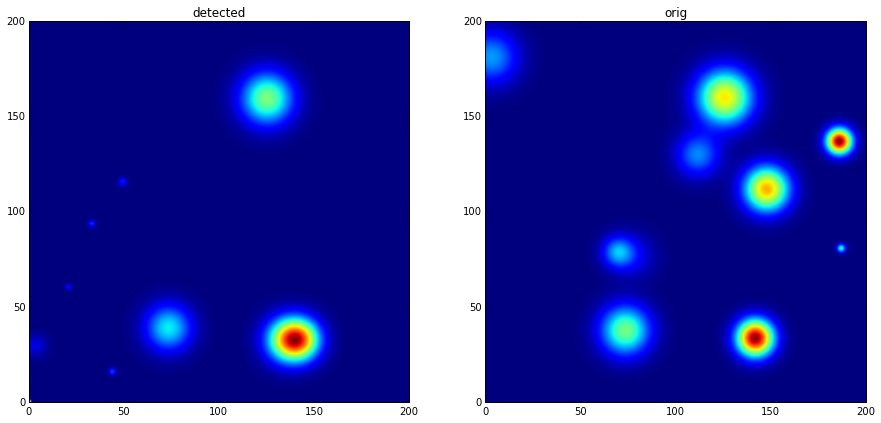

In [21]:
initial_bounds = np.array([[0, width], [0, height]])
k = get_peaks(av, initial_bounds)
sources = get_sources(k, av)
look_at_results(sources)

In [22]:
sources

array([[  1.24495050e+02,   1.58448255e+02,   7.85072400e+00,
          9.31394000e+00,   0.00000000e+00,  -1.05699566e+05],
       [  1.42079255e+02,   3.22039780e+01,   9.24120700e+00,
          7.34560300e+00,   1.00000000e+00,  -1.05796645e+05],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.34764985e+02,   3.20348380e+01,   8.20737300e+00,
          7.96617800e+00,   1.00000000e+00,  -1.06751140e+05],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],


/Users/richard/miniconda/envs/np/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: RuntimeWarning: divide by zero encountered in divide
/Users/richard/miniconda/envs/np/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: RuntimeWarning: invalid value encountered in divide


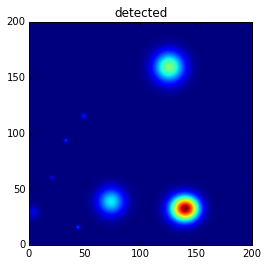

In [23]:
look_at_results2(sources)

In [102]:
myindex = np.array([0,1,-1])

In [103]:
a[:, myindex]

array([[  1.24158029e+02,   1.58835898e+02,  -1.05699945e+05],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.24158029e+02,   1.58835898e+02,  -2.05699945e+05]])

In [54]:
a = np.array([[  1.24158029e+02,   1.58835898e+02,   7.71783784e+00,   9.33707437e+00,
    0.00000000e+00,  -1.05699945e+05],
 [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
    0.00000000e+00,   0.00000000e+00],
    [  1.24158029e+02,   1.58835898e+02,   7.71783784e+00,   9.33707437e+00,
    0.00000000e+00,  -2.05699945e+05]         ])

In [82]:
t = (a == a[0]).all(axis=1)

In [89]:
q = np.array([1,2,3])

In [101]:
np.c_[a, q].shape

(3, 7)

In [99]:
q.T

array([1, 2, 3])

In [95]:
a.shape

(3, 6)

In [93]:
np.hstack((a, q.T))

ValueError: all the input arrays must have same number of dimensions

In [88]:
q[np.where(t == True)[0]]

1

In [79]:
np.any(t)

False

In [64]:
b = a*2

In [69]:
b[1] = b[1]+1

In [70]:
b

array([[  2.48316058e+02,   3.17671796e+02,   1.54356757e+01,
          1.86741487e+01,   0.00000000e+00,  -2.11399890e+05],
       [  1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00],
       [  2.48316058e+02,   3.17671796e+02,   1.54356757e+01,
          1.86741487e+01,   0.00000000e+00,  -4.11399890e+05]])

In [72]:
b[2]

array([  2.48316058e+02,   3.17671796e+02,   1.54356757e+01,
         1.86741487e+01,   0.00000000e+00,  -4.11399890e+05])

In [71]:
np.any(a == b[2])

True

In [60]:
a[0]

array([  1.24158029e+02,   1.58835898e+02,   7.71783784e+00,
         9.33707437e+00,   0.00000000e+00,  -1.05699945e+05])

In [56]:
q = a[a[:, -1].argsort()]

In [50]:
np.sort(a, axis=0)

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,  -1.05699945e+05],
       [  1.24158029e+02,   1.58835898e+02,   7.71783784e+00,
          9.33707437e+00,   0.00000000e+00,  -1.05699945e+05],
       [  1.24158029e+02,   1.58835898e+02,   7.71783784e+00,
          9.33707437e+00,   0.00000000e+00,   0.00000000e+00]])

In [35]:
a.nonzero()

(array([0, 0, 0, 0, 0, 2, 2, 2, 2, 2]), array([0, 1, 2, 3, 5, 0, 1, 2, 3, 5]))

In [39]:
a[~np.all(a == 0, axis=1)]

array([[  1.24158029e+02,   1.58835898e+02,   7.71783784e+00,
          9.33707437e+00,   0.00000000e+00,  -1.05699945e+05],
       [  1.24158029e+02,   1.58835898e+02,   7.71783784e+00,
          9.33707437e+00,   0.00000000e+00,  -1.05699945e+05]])

In [32]:
a[:, 0:2]

array([[ 124.158029,  158.835898],
       [   0.      ,    0.      ]])

In [43]:
a = np.array([[1,2,3], [1,1,1]])
b = np.array([2,3,4])

In [45]:
q = np.vstack((a,b))

In [47]:
q

array([[1, 2, 3],
       [1, 1, 1],
       [2, 3, 4]])

In [48]:
np.sort(q, axis=1)

array([[1, 2, 3],
       [1, 1, 1],
       [2, 3, 4]])